AI/ML project for a graduate level course in optimization for industrial systems

Tested on the NASA open-source dataset found in  https://data.nasa.gov/dataset/ims-bearings


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



df = pd.read_csv("../data/IMS/1st_test/2003.11.23.20.11.24", sep="\t")

df0 = pd.read_csv("../data/IMS/1st_test/2003.11.23.20.21.24", sep="\t", )

df.columns = ["B1_X", "B1_Y","B2_X", "B2_Y","B3_X", "B3_Y","B4_X", "B4_Y" ]
df0.columns = ["B1_X", "B1_Y","B2_X", "B2_Y","B3_X", "B3_Y","B4_X", "B4_Y" ]

df.head()




,B1_X,B1_Y,B2_X,B2_Y,B3_X,B3_Y,B4_X,B4_Y
0,-0.176,0.044,-0.107,-0.039,-0.198,-0.051,-0.039,-0.186
1,-0.237,-0.007,-0.264,-0.137,-0.083,-0.239,-0.051,-0.186
2,-0.151,-0.110,-0.256,-0.195,-0.146,-0.149,-0.310,-0.042
3,-0.200,-0.168,-0.066,-0.195,-0.300,-0.198,-0.300,0.085
4,-0.330,-0.034,-0.212,-0.220,-0.171,-0.020,-0.134,-0.149


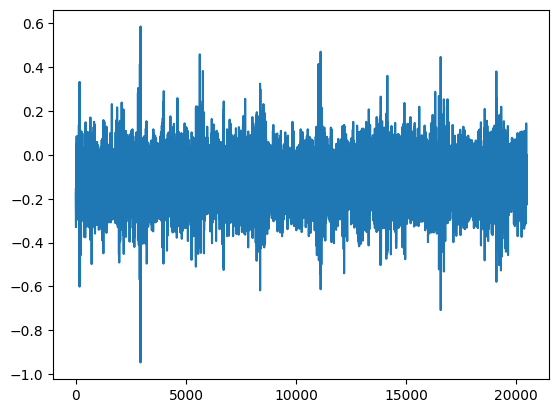

In [13]:
df["B1_X"].plot()
plt.show()

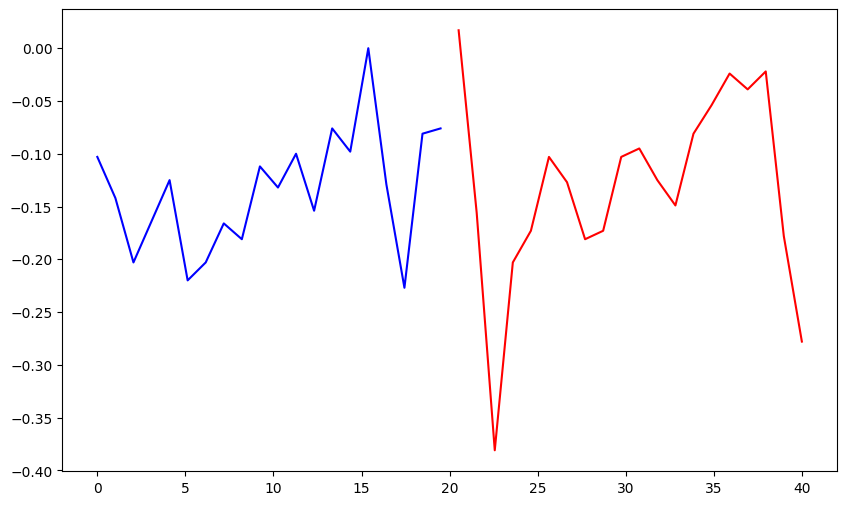

In [14]:
df1_last_10 = df.tail(20)  # Last 10 rows of df1
df2_first_10 = df0.head(20)  # First 10 rows of df2

plt.figure(figsize=(10, 6))

index = np.linspace(0, 40, 40)

# Plot the last 10 points from df1
plt.plot(index[0:20], df1_last_10['B1_X'], color='b')

# Plot the first 10 points from df2
plt.plot(index[20:40],df2_first_10['B1_X'], color='r')

plt.show()

In [15]:
import os

path = "../data/IMS/1st_test/"
data_filename = "1st_test_data"
data_file = os.path.join(path,data_filename)

if not os.path.isfile(data_file):

    filenames = []

    for (root, _, files) in os.walk(path):
        for file in files:
            filenames.append(os.path.join(root,file)) 

    filenames.sort()

    with open(data_file, 'wb') as outfile:
        for fname in filenames:
            with open(fname, 'rb') as infile:
                    outfile.write(infile.read())


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20479 entries, 0 to 20478
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   B1_X    20479 non-null  float64
 1   B1_Y    20479 non-null  float64
 2   B2_X    20479 non-null  float64
 3   B2_Y    20479 non-null  float64
 4   B3_X    20479 non-null  float64
 5   B3_Y    20479 non-null  float64
 6   B4_X    20479 non-null  float64
 7   B4_Y    20479 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


In [17]:
# df = pd.read_csv("../data/IMS/1st_test/1st_test_data", sep="\t" ,usecols=[6], dtype= {6 : "float32"})

# df.columns = ["X"]
# df["X"].plot(figsize=(18,6))
# plt.show()

In [54]:
from scipy.fft import fft, fftfreq
from scipy.signal import welch
from scipy.stats import entropy
from scipy.signal import butter, filtfilt
from scipy.ndimage import gaussian_filter1d

b = 4

bearings = {
        "bearing_1": [0, 1],
        "bearing_2": [2, 3],
        "bearing_3": [4, 5],
        "bearing_4": [6, 7]
    }

bearing = bearings[f"bearing_{b}"]

def butter_lowpass(cutoff, fs, order=4):
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist  # Normalize the cutoff frequency
    b, a = butter(order, normal_cutoff, btype='low', analog=False)  # Butterworth filter coefficients
    return b, a

# Apply the low-pass filter to the signal
def butter_lowpass_filter(data, cutoff, fs, order=4):
    b, a = butter_lowpass(cutoff, fs, order)
    return filtfilt(b, a, data)  # Apply the filter with zero-phase distortion



N_tot = len(df)
N = 20000    # Chunk size
fs = 20e3
T = 1 / fs # Sampling frequency

""" Magnitude """

features = ["t_mean", "fft_mean", "fft_max", "fft_spec_centroid", "fft_dominant_frequency", "fft_entropy"]


path = "../data/IMS/1st_test/"
feature_file = os.path.join(path, f"features_{b}.csv")




if not os.path.isfile(feature_file):



    filenames = []

    for (root, _, files) in os.walk(path):
        for file in files:
            if file.startswith('200'):
                filenames.append(os.path.join(root,file)) 


    filenames.sort()
    i = 0
    
    for file in filenames:

        print(f"parsing file: {i}, out of {len(filenames)}")
        i = i + 1


        df = pd.read_csv(file, sep="\t",usecols=bearing, dtype= {bearing[0] : "float32", bearing[1] : "float32" })

        cutoff = 5000

        
        N = len(df)

        df.columns = ["X", "Y"]
        df["Mag"] = np.sqrt(df["X"]**2 + df["Y"]**2)

        
        
        df["gauss"] = gaussian_filter1d(df["Mag"], sigma=5)

        df["filtered"] = butter_lowpass_filter(df["gauss"], cutoff, fs)

        yf = fft(df["filtered"])
        # xf = fftfreq(N, T)[:N//2]
        f, Pxx = welch(df["filtered"].values, fs=fs, nperseg=512)

        feature = [np.mean(df["Mag"]), 
                    np.mean(np.abs(yf)[5:]),
                    np.max(np.abs(yf)[5:]), 
                    np.sum(f * Pxx) / np.sum(Pxx),
                    f[np.argmax(Pxx)],
                    entropy(Pxx / np.sum(Pxx))
                  ]

        df_features = pd.DataFrame([feature], columns=features)

        df_features.to_csv(feature_file, mode="a", header=False, index=False)
    
        

parsing file: 0, out of 2156
parsing file: 1, out of 2156
parsing file: 2, out of 2156
parsing file: 3, out of 2156
parsing file: 4, out of 2156
parsing file: 5, out of 2156
parsing file: 6, out of 2156
parsing file: 7, out of 2156
parsing file: 8, out of 2156
parsing file: 9, out of 2156
parsing file: 10, out of 2156
parsing file: 11, out of 2156
parsing file: 12, out of 2156
parsing file: 13, out of 2156
parsing file: 14, out of 2156
parsing file: 15, out of 2156
parsing file: 16, out of 2156
parsing file: 17, out of 2156
parsing file: 18, out of 2156
parsing file: 19, out of 2156
parsing file: 20, out of 2156
parsing file: 21, out of 2156
parsing file: 22, out of 2156
parsing file: 23, out of 2156
parsing file: 24, out of 2156
parsing file: 25, out of 2156
parsing file: 26, out of 2156
parsing file: 27, out of 2156
parsing file: 28, out of 2156
parsing file: 29, out of 2156
parsing file: 30, out of 2156
parsing file: 31, out of 2156
parsing file: 32, out of 2156
parsing file: 33, ou

In [49]:
# features = []

# preprocessing ideas
# Feature extraction, fft, chunks? max min mean range, 

# fft, stft

# Spectral Centroid“Center of mass” of spectrum Weighted average of frequencies
# Each row (chunk) becomes one feature vector [mean amplitude, max amplitude, dominant frequency].
# Autoregressive (AR) spectral features → more compact spectral representation
# Dominant Frequency Frequency with max amplitude Often most interpretable
# Spectral EntropyUniformity of spectral power Flat = high entropy, narrowband = low entropy

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20479 entries, 0 to 20478
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   X         20479 non-null  float32
 1   Y         20479 non-null  float32
 2   Mag       20479 non-null  float32
 3   gauss     20479 non-null  float32
 4   filtered  20479 non-null  float64
dtypes: float32(4), float64(1)
memory usage: 480.1 KB


In [ ]:
b = 3

df = pd.read_csv("../data/IMS/1st_test/features_{b}.csv")
df.columns = ["t_mean", "fft_mean", "fft_max", "fft_spec_centroid", "fft_dominant_frequency", "fft_entropy"]
df = df.iloc[175:]

df.head()


,t_mean,fft_mean,fft_max,fft_spec_centroid,fft_dominant_frequency,fft_entropy
175,0.182342,0.908954,76.711124,321.709718,78.1250,2.986119
176,0.181806,0.871728,74.737598,323.289267,78.1250,2.975730
177,0.181079,0.935402,71.243310,325.136483,39.0625,2.993896
178,0.181876,0.869247,79.230645,335.165774,468.7500,2.989854
179,0.181646,0.880387,62.940453,332.936150,468.7500,3.001397


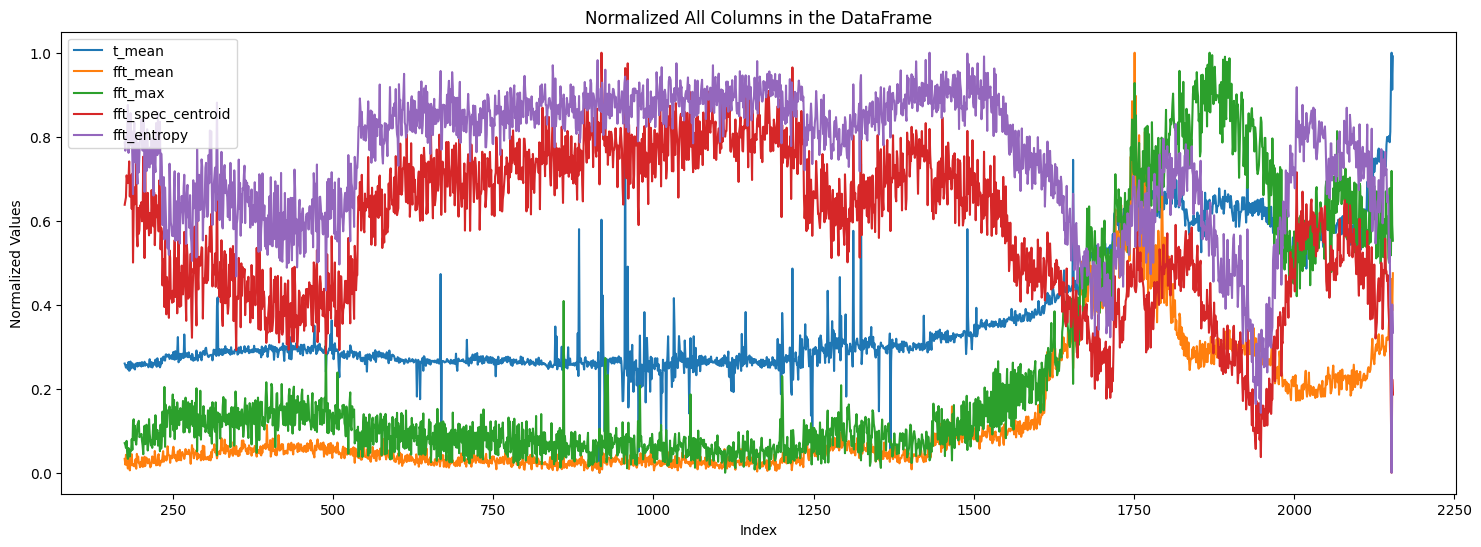

In [57]:

df_normalized = (df - df.min()) / (df.max() - df.min())
df_normalized = df_normalized.drop(columns=["fft_dominant_frequency"])


normalized_file = os.path.join(path, f"features_normalized_{b}.csv")
df_normalized.to_csv(normalized_file, mode="a", index=False)


df_normalized.plot(figsize=(18,6))

plt.xlabel('Index')
plt.ylabel('Normalized Values')
plt.title('Normalized All Columns in the DataFrame')

plt.show()


<Axes: >

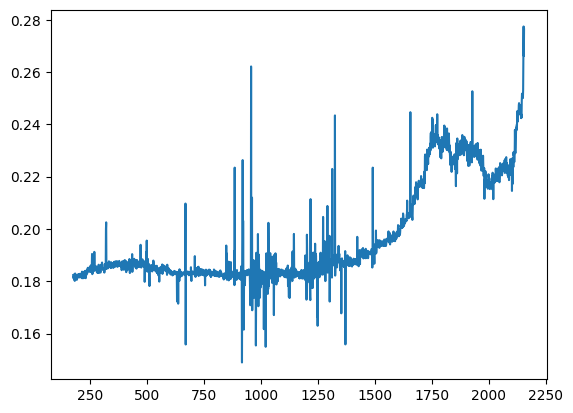

In [61]:

df["t_mean"].plot()


<Axes: >

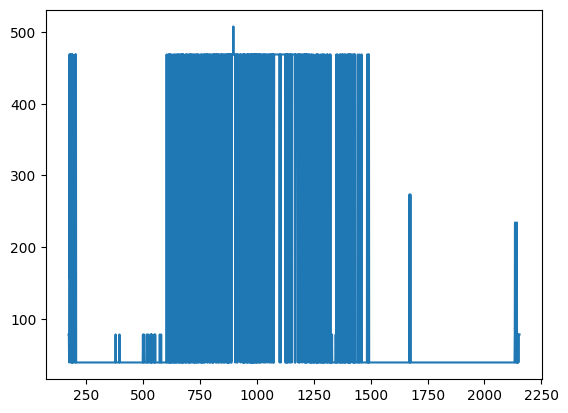

In [24]:
df["fft_dominant_frequency"].plot()

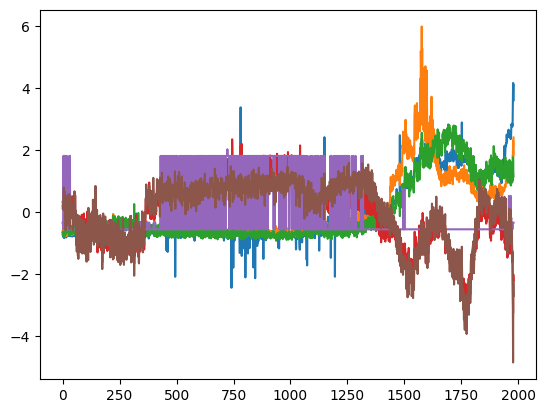

In [59]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

plt.plot(X_scaled)
plt.show()

scaled_file = os.path.join(path, f"features_scaled_{b}.csv")


scaled_df = pd.DataFrame(X_scaled, columns=df.columns)
scaled_df.to_csv(scaled_file, index=False)
